In [1]:
import numpy as np
import pandas as pd
import os, json, cv2, random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras import callbacks
from utils import *
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping
import seaborn as sns

Init Plugin
Init Graph Optimizer
Init Kernel


In [5]:
with open('../../data/tumor_segmentation/train/_annotations.coco.json', 'r') as f:
    data = json.load(f)
    
with open('../../data/tumor_segmentation/valid/_annotations.coco.json', 'r') as f:
    data_valid = json.load(f)
    
with open('../../data/tumor_segmentation/test/_annotations.coco.json', 'r') as f:
    data_test = json.load(f)

In [6]:
data.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [7]:
data['info']

{'year': '2023',
 'version': '1',
 'description': 'Exported from roboflow.com',
 'contributor': '',
 'url': 'https://public.roboflow.com/object-detection/undefined',
 'date_created': '2023-08-19T04:37:54+00:00'}

In [8]:
data['licenses']

[{'id': 1,
  'url': 'https://creativecommons.org/licenses/by/4.0/',
  'name': 'CC BY 4.0'}]

In [9]:
data['categories']

[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

In [10]:
len(data['images'])

1502

In [11]:
data['images'][48]

{'id': 48,
 'license': 1,
 'file_name': '1173_jpg.rf.412cac70c878dda826eb8537d371693c.jpg',
 'height': 640,
 'width': 640,
 'date_captured': '2023-08-19T04:37:54+00:00'}

In [12]:
data['annotations'][48]

{'id': 48,
 'image_id': 48,
 'category_id': 2,
 'bbox': [259, 214, 128.75, 105],
 'area': 13518.75,
 'segmentation': [[387.5,
   213.75,
   258.75,
   213.75,
   258.75,
   318.75,
   387.5,
   318.75,
   387.5,
   213.75]],
 'iscrowd': 0}

In [13]:
data['annotations'][0]

{'id': 0,
 'image_id': 0,
 'category_id': 1,
 'bbox': [145, 239, 168.75, 162.5],
 'area': 27421.875,
 'segmentation': [[313.75,
   238.75,
   145,
   238.75,
   145,
   401.25,
   313.75,
   401.25,
   313.75,
   238.75]],
 'iscrowd': 0}

In [14]:
set([(x['height'],x['width']) for x in data['images']])

{(640, 640)}

In [15]:
main_path = '../../data/tumor_segmentation/train/'
main_path_valid = '../../data/tumor_segmentation/valid/'
main_path_test = '../../data/tumor_segmentation/test/'

tumor_path = main_path

files = [main_path + x for x in os.listdir(main_path) if not x.endswith('json')]
files_valid = [main_path_valid + x for x in os.listdir(main_path_valid) if not x.endswith('json')]
files_test = [main_path_test + x for x in os.listdir(main_path_test) if not x.endswith('json')]

In [16]:
tumor, tumor_bbox = load_images(files, data)
tumor_valid, tumor_valid_bbox = load_images(files_valid, data_valid)
tumor_test, tumor_test_bbox = load_images(files_test, data_test)

In [17]:
tumor_gray_final = image_preprocess(tumor)
tumor_valid_gray_final = image_preprocess(tumor_valid)
tumor_test_gray_final = image_preprocess(tumor_test)

In [18]:

def image_mask_preprocess(data):
    y = data['bbox']
    y =[[x*256/640 for x in q] for q in y]
    return y

In [19]:
y = image_mask_preprocess(tumor_bbox)
X = np.array(tumor_gray_final)

y_valid = image_mask_preprocess(tumor_valid_bbox)
X_valid = np.array(tumor_valid_gray_final)

y_test = image_mask_preprocess(tumor_test_bbox)
X_test = np.array(tumor_test_gray_final)

In [20]:
len(X) == len(y), len(X_valid) == len(y_valid), len(X_test) == len(y_test) 

(True, True, True)

In [21]:
masks = create_masks(y)
masks_valid = create_masks(y_valid)
masks_test = create_masks(y_test)

In [22]:
image_slider(tumor_gray_final, masks = masks)

interactive(children=(IntSlider(value=0, description='index', max=1500), Output()), _dom_classes=('widget-inte…

In [23]:
H = 256
W = 256

batch_size = 10
epochs = 100

In [204]:
model = unet((H, W, 1))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_286 (Conv2D)             (None, 256, 256, 64) 640         input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_292 (BatchN (None, 256, 256, 64) 256         conv2d_286[0][0]                 
__________________________________________________________________________________________________
activation_274 (Activation)     (None, 256, 256, 64) 0           batch_normalization_292[0][0]    
_______________________________________________________________________________________________

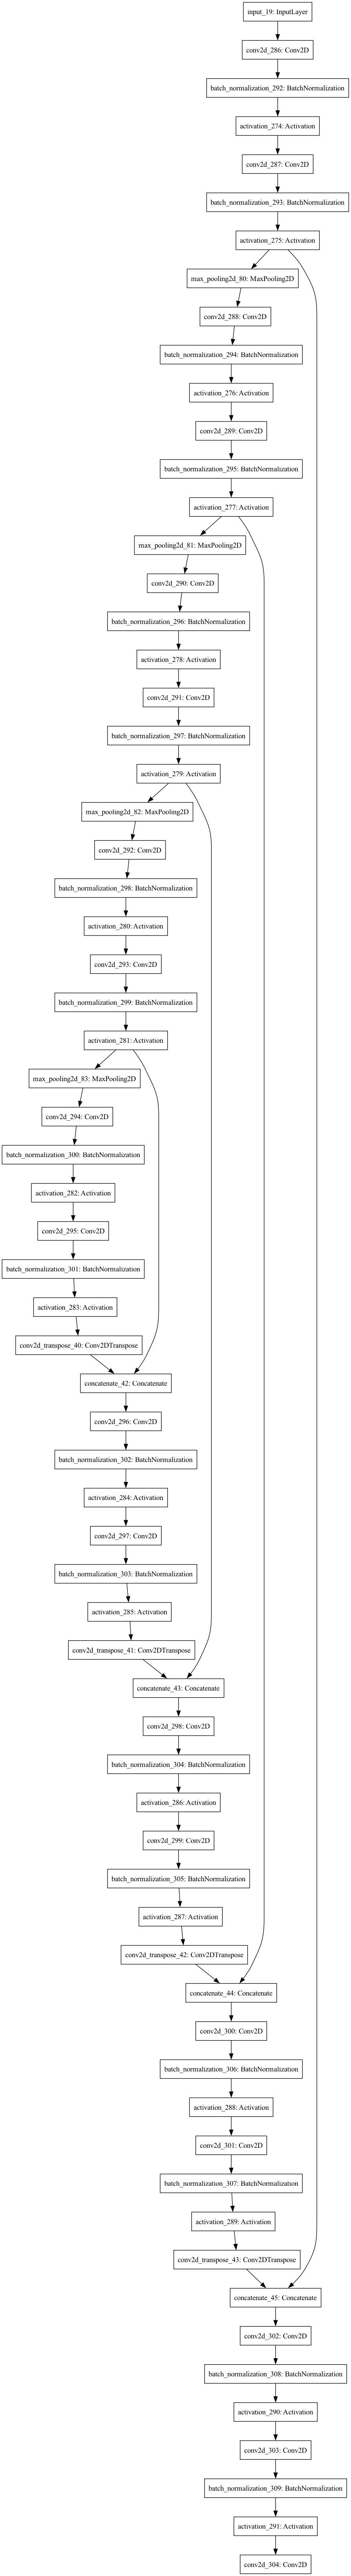

In [5]:
plot_model(model)

In [ ]:
model.compile(loss = dice_loss, optimizer = 'adam', metrics = [dice_coef,'accuracy'])

In [205]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)]

In [207]:
history = model.fit(np.expand_dims(X,-1), np.array(masks), verbose = 1, epochs = epochs, batch_size = batch_size, validation_split = 0.2, callbacks = callbacks)

Epoch 1/100


2024-02-19 03:17:32.164941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 0.7719 - dice_coef: 0.2281 - accuracy: 0.8233

2024-02-19 03:20:00.733971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 164s 1s/step - loss: 0.7713 - dice_coef: 0.2287 - accuracy: 0.8239 - val_loss: 0.9290 - val_dice_coef: 0.0709 - val_accuracy: 0.0443
Epoch 2/100
120/120 [==============================] - 173s 1s/step - loss: 0.5825 - dice_coef: 0.4175 - accuracy: 0.9572 - val_loss: 0.9539 - val_dice_coef: 0.0453 - val_accuracy: 0.4612
Epoch 3/100
120/120 [==============================] - 1088s 9s/step - loss: 0.5186 - dice_coef: 0.4814 - accuracy: 0.9602 - val_loss: 0.9264 - val_dice_coef: 0.0737 - val_accuracy: 0.1541
Epoch 4/100
120/120 [==============================] - 707s 6s/step - loss: 0.4893 - dice_coef: 0.5107 - accuracy: 0.9632 - val_loss: 0.9086 - val_dice_coef: 0.0911 - val_accuracy: 0.2776
Epoch 5/100
120/120 [==============================] - 1341s 11s/step - loss: 0.4438 - dice_coef: 0.5562 - accuracy: 0.9661 - val_loss: 0.7531 - val_dice_coef: 0.2457 - val_accuracy: 0.8242
Epoch 6/100
120/120 [==============================] - 1098s 9s/step 

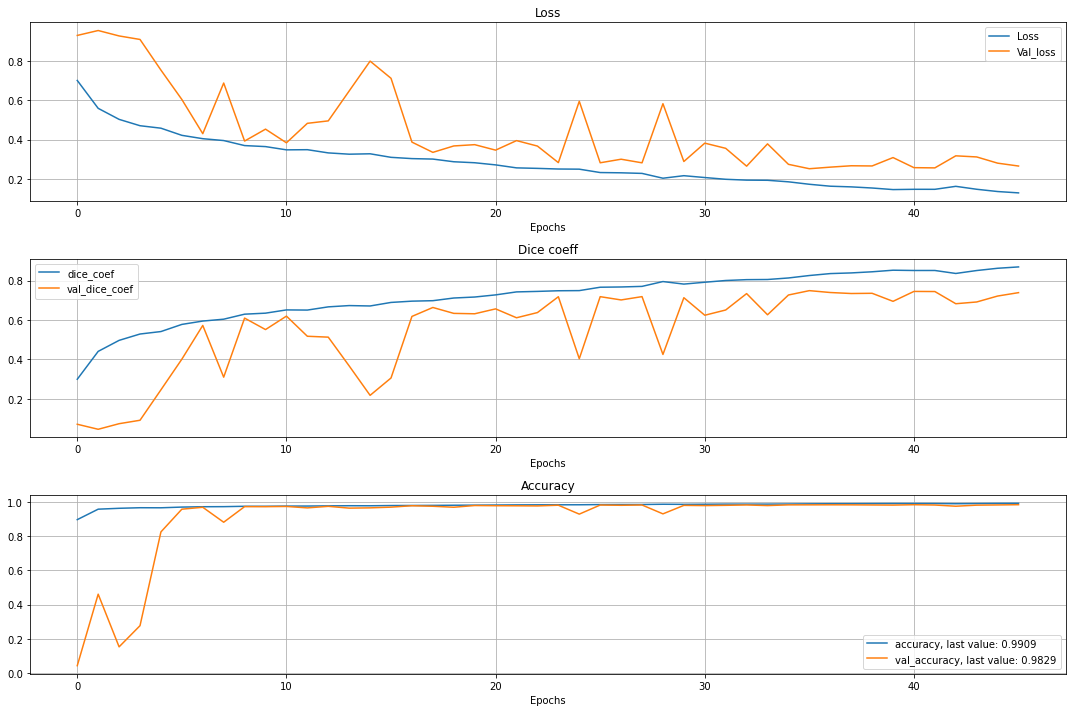

In [319]:
fig, axs = plt.subplots(3,1, figsize = (15,10))
axs = axs.flatten()

axs[0].plot(history.history['loss'], label = 'Loss')
axs[0].plot(history.history['val_loss'], label = 'Val_loss')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_title('Loss')
axs[0].grid()

axs[1].plot(history.history['dice_coef'], label = 'dice_coef')
axs[1].plot(history.history['val_dice_coef'], label = 'val_dice_coef')
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].grid()
axs[1].set_title('Dice coeff')

axs[2].plot(history.history['accuracy'], label = f'accuracy, last value: {round(history.history["accuracy"][-1],4)}')
axs[2].plot(history.history['val_accuracy'], label = f'val_accuracy, last value: {round(history.history["val_accuracy"][-1],4)}')
axs[2].legend()
axs[2].set_xlabel('Epochs')
axs[2].grid()
axs[2].set_title(f'Accuracy')


fig.tight_layout()

In [308]:
pd.DataFrame(history.history).to_csv('misc/cnn_seg_1_history.csv')

In [211]:
model.save('models/seg_cnn_1.h5')

INFO:tensorflow:Assets written to: models/seg_cnn_1/assets


In [2]:
model = tf.keras.models.load_model('models/seg_cnn_1.h5', custom_objects = {'dice_loss': dice_loss, 'dice_coef': dice_coef})

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-02-19 20:26:48.947228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-19 20:26:48.947685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:
y_pred_train = get_set_prediction(X, model)
y_pred_valid = get_set_prediction(X_valid, model)
y_pred_test = get_set_prediction(X_test, model)

2024-02-19 19:56:24.296925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


* Train set

In [23]:
image_slider(X, masks= y_pred_train)

interactive(children=(IntSlider(value=0, description='index', max=1500), Output()), _dom_classes=('widget-inte…

* Validation set

In [24]:
image_slider(X_valid, masks= y_pred_valid)

interactive(children=(IntSlider(value=0, description='index', max=428), Output()), _dom_classes=('widget-inter…

* Test set

In [25]:
image_slider(X_test, masks= y_pred_test)

interactive(children=(IntSlider(value=0, description='index', max=214), Output()), _dom_classes=('widget-inter…

* One image each time

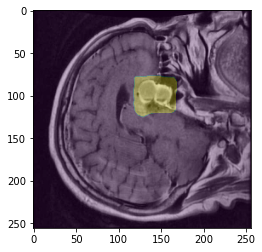

In [26]:
idx = 200
plt.imshow(X_test[idx], cmap = 'gray')
plt.imshow(np.squeeze(get_one_prediction(X_test[idx], model)), alpha = 0.3)

2024-02-19 19:55:49.699125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-02-19 19:55:49.699403: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-19 19:55:49.834401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


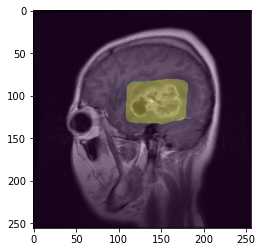

In [25]:
img = cv2.imread('../../data/tumor_detection/Brain Tumor Data Set/Brain Tumor/Cancer (464).jpg')
img_p = image_preprocess([img])
plt.imshow(img_p[0], cmap = 'gray')
plt.imshow(np.squeeze(get_one_prediction(img_p[0], model)), alpha = 0.3)

## Metrics

In [29]:
area_train = [x.sum() for x in masks]
area_pred_train = [x.sum() for x in y_pred_train]

area_valid = [x.sum() for x in masks_valid]
area_pred_valid = [x.sum() for x in y_pred_valid]

area_test = [x.sum() for x in masks_test]
area_pred_test = [x.sum() for x in y_pred_test]

In [30]:
prods_train = [x*y[:,:,0] for x,y in zip(np.array(masks),y_pred_train)]
areas_train = [(x.sum(), y.sum(), z.sum()) for x,y,z in zip(np.array(masks), prods_train, y_pred_train)]
areas_train = pd.DataFrame(areas_train, columns = ['Actual','Common', 'Predicted'])
areas_train['Dice_coeff'] = 2*areas_train['Common']/(areas_train['Predicted'] + areas_train['Actual'])
areas_train['Ratio'] = areas_train['Common']/areas_train['Actual']

prods_valid = [x*y[:,:,0] for x,y in zip(np.array(masks_valid),y_pred_valid)]
areas_valid = [(x.sum(), y.sum(), z.sum()) for x,y,z in zip(np.array(masks), prods_train, y_pred_valid)]
areas_valid = pd.DataFrame(areas_valid, columns = ['Actual','Common', 'Predicted'])
areas_valid['Dice_coeff'] = 2*areas_valid['Common']/(areas_valid['Predicted'] + areas_valid['Actual'])
areas_valid['Ratio'] = areas_valid['Common']/areas_valid['Actual']

prods_test = [x*y[:,:,0] for x,y in zip(np.array(masks_test),y_pred_test)]
areas_test = [(x.sum(), y.sum(), z.sum()) for x,y,z in zip(np.array(masks), prods_train, y_pred_test)]
areas_test = pd.DataFrame(areas_test, columns = ['Actual','Common', 'Predicted'])
areas_test['Dice_coeff'] = 2*areas_test['Common']/(areas_test['Predicted'] + areas_test['Actual'])
areas_test['Ratio'] = areas_test['Common']/areas_test['Actual']

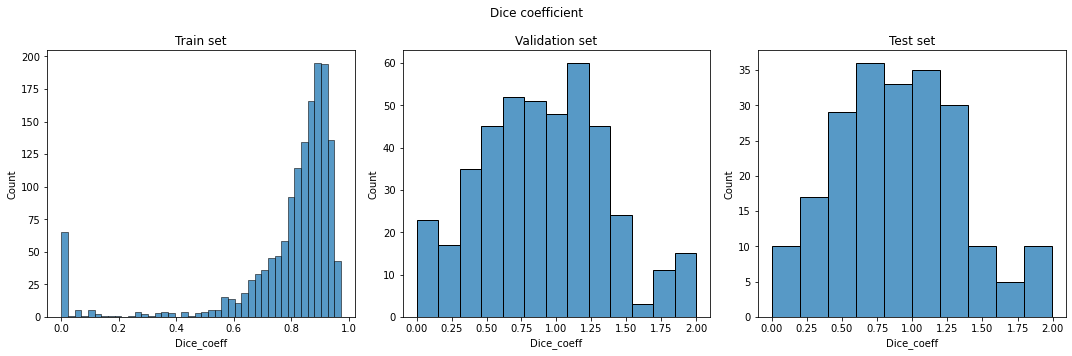

In [31]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
axs = axs.flatten()

sns.histplot(areas_train['Dice_coeff'], ax = axs[0])
axs[0].set_title('Train set')
sns.histplot(areas_valid['Dice_coeff'], ax = axs[1])
axs[1].set_title('Validation set')
sns.histplot(areas_test['Dice_coeff'], ax = axs[2])
axs[2].set_title('Test set')

fig.suptitle('Dice coefficient')

fig.tight_layout()

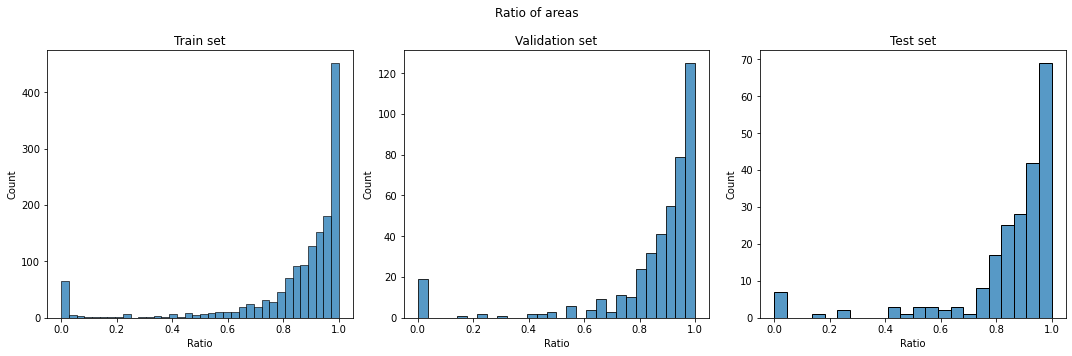

In [32]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
axs = axs.flatten()

sns.histplot(areas_train['Ratio'], ax = axs[0])
axs[0].set_title('Train set')
sns.histplot(areas_valid['Ratio'], ax = axs[1])
axs[1].set_title('Validation set')
sns.histplot(areas_test['Ratio'], ax = axs[2])
axs[2].set_title('Test set')

fig.suptitle('Ratio of areas')

fig.tight_layout()